In [1]:
from autoencoder_trainer import *

In [2]:
training_dir = "/Users/afq/Google Drive/networks/"
data_dir = "/Users/afq/Dropbox/ML/primaryautoencoder/data_files/"
n_epoch = 25000
dataset = tf.data.experimental.make_csv_dataset(
    data_dir+'water_lg_sharded/*.csv',
    5000,
    select_columns=['T',' p',' rho',' h'],
    column_defaults=[tf.float64,tf.float64,tf.float64,tf.float64]
)
# hyper = {'type':'Poly','args':[1,7]}
hyper = {'type':'Classifying','args':[1,3, 6,12,'sigmoid']}
name = "water_lg"
outerdim,innerdim=4,2

In [3]:
data_all = np.load(data_dir+"water_lg_scaled_train.npy")

In [4]:
dataset_all = tf.data.Dataset.from_tensors(data_all)

In [5]:
dataset_all_from_shards = tf.data.experimental.make_csv_dataset(
    data_dir+'water_lg_sharded/*.csv',
    10000,
    select_columns=['T',' p',' rho',' h'],
    column_defaults=[tf.float64,tf.float64,tf.float64,tf.float64]
)

In [6]:
autoclass = autoencoder_factory[hyper['type']]
def sanitize(x):
    return str(x).replace(' ','').replace('[','(').replace(']',')')
hyperpath = hyper['type']+'_'+','.join(map(sanitize,hyper['args']))
training_dir = training_dir+"/training_"+name+"/"+hyperpath

In [7]:
stream = atu.make_datastream(dataset,batch_size=0,buffer_size=1000)
stream = tf.transpose(stream)
global_step = tf.train.get_or_create_global_step()
onum = tf.Variable(0,name="csv_output_num")
stream_all = dataset_all.repeat().make_one_shot_iterator().get_next()
ae = autoclass(outerdim, innerdim, stream, *hyper['args'], data_all=stream_all)
init = tf.global_variables_initializer()

[(0, 216), (216, 240)]
(240, 1)


In [8]:
newt_select = atu.NewtonsMethod(ae.goal_all, ae.vars['dec_W_select'])
#newt_bound = atu.NewtonsMethod(ae.goal_all, [ae.vars['dec_W_bound'],ae.vars['dec_b_bound']])

[(0, 72)]
(72, 1)


In [9]:
session = tf.train.MonitoredTrainingSession(
            checkpoint_dir=training_dir)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /Users/afq/Google Drive/networks//training_water_lg/Classifying_1,3,6,12,sigmoid/model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 15000 into /Users/afq/Google Drive/networks//training_water_lg/Classifying_1,3,6,12,sigmoid/model.ckpt.


In [10]:
prev_val = session.run(ae.vars["dec_W_curve"])
prev_val

array([[[-4.49193500e-01, -9.42413776e-01,  4.64288804e-01,
         -4.32534551e-01],
        [-8.03622040e-01, -5.88860994e-01,  1.50214430e-01,
         -2.85146631e-01],
        [-3.77054259e-01, -6.80454366e-01,  4.01666019e-01,
         -4.44500725e-01],
        [-1.77069205e-01, -9.15899592e-01,  5.97771866e-01,
         -1.96464619e-01],
        [-2.59115496e-01, -7.65210252e-01,  3.39360361e-01,
         -2.30820910e-01],
        [ 8.07865700e-03, -1.26170211e+00,  9.06941086e-01,
         -6.46782512e-01]],

       [[ 1.57094325e-01, -2.06928024e-01, -6.33083597e-01,
          5.28151826e-01],
        [ 2.32822504e-01, -8.83541042e-01, -5.40053062e-01,
          4.47388196e-01],
        [ 2.07027949e-01, -3.95492107e-01, -3.63375074e-01,
          3.78809540e-01],
        [ 8.18963559e-02, -3.87523553e-01, -6.23557064e-01,
          5.57118993e-01],
        [ 2.04845573e-01, -5.41850342e-01, -3.97508187e-01,
          3.93648243e-01],
        [-8.30213265e-02, -3.86734064e-01

In [11]:
prvW,prvb = session.run(ae._get_hess_vars())
for i in range(2):
    la,(newW,newb) = session.run([ae.goal_all,ae.newt_step])
    print(la,np.linalg.norm(newW-prvW),np.linalg.norm(newb-prvb))
    prvW,prvb = newW,newb

(7.813218e-06, 20560.338141179054, 3465.3187097350437)
(1.2707386e-06, 92.46532426052939, 23.621297867130817)


In [12]:
prvW,prvb = session.run(ae._get_hess_vars())
for i in range(2):
    la,(newW,newb) = session.run([ae.goal_all,ae.newt_step])
    print(la,np.linalg.norm(newW-prvW),np.linalg.norm(newb-prvb))
    prvW,prvb = newW,newb

(1.2707354e-06, 0.7575061952641573, 0.1946393737954976)
(1.2707353e-06, 0.007936955605645647, 0.0018660225433315095)


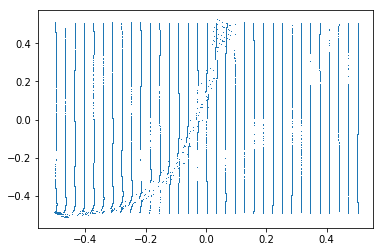

In [13]:
ae.save_fit('newton_solve.csv','T,p,rho,h',sess=session,samples=20)

In [14]:
prvW,prvb = session.run(ae._get_hess_vars())
for i in range(2):
    la,(newW,newb) = session.run([ae.goal_all,ae.newt_step])
    print(la,np.linalg.norm(newW-prvW),np.linalg.norm(newb-prvb))
    prvW,prvb = newW,newb

(1.2707353e-06, 0.0005958210940069066, 0.0001304809303565853)
(1.2707353e-06, 0.0005245183677339869, 8.558468432946778e-05)


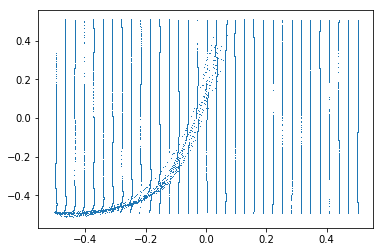

In [15]:
ae.save_fit('newton_solve.csv','T,p,rho,h',sess=session,samples=20)

In [16]:
prvW,prvb = session.run(ae._get_hess_vars())
for i in range(4):
    la,(newW,newb) = session.run([ae.goal_all,ae.newt_step])
    print(la,np.linalg.norm(newW-prvW),np.linalg.norm(newb-prvb))
    prvW,prvb = newW,newb

(1.2707353e-06, 0.0004887055545761591, 0.00010159545531448077)
(1.2707353e-06, 0.0005841901209653312, 0.00011373267826454407)
(1.2707353e-06, 0.0006273397108892063, 0.0001251914614369141)
(1.2707353e-06, 0.0006606576837402436, 0.00013531064763110175)


In [17]:
newW

array([[[ 7.35537569e-04, -1.26435935e+00,  7.86100220e-01,
         -7.81349546e-01],
        [-1.03216841e+00, -4.86675444e-01, -6.83416562e-02,
         -1.25415263e-01],
        [-2.98141626e+03,  2.33512596e+03, -2.92662551e+03,
          1.40979316e+03],
        [ 4.98206910e+02, -3.97168737e+02,  5.17565991e+02,
         -2.07599071e+02],
        [ 2.42494260e+03, -1.89243245e+03,  2.33581183e+03,
         -1.19622598e+03],
        [-2.23346972e-01, -1.12066079e+00,  7.26604735e-01,
         -5.07267357e-01]],

       [[-1.96817744e+00,  1.12635467e+00, -2.52056586e+00,
          1.85042629e+00],
        [ 7.51090751e-01, -9.28828453e-01, -2.31843369e-01,
          1.64679785e-01],
        [ 4.44788601e+03, -3.49912632e+03,  4.43277902e+03,
         -2.03430654e+03],
        [-1.36727396e+02,  1.13033295e+02, -1.66557005e+02,
          3.23984339e+01],
        [-4.12630398e+03,  3.23536221e+03, -4.06322643e+03,
          1.94155278e+03],
        [ 1.68767601e+00, -1.66353347e+00

In [18]:
newb

array([[ 1.86993933e+00, -1.38958159e+00,  1.66659774e+00,
        -9.31196959e-01],
       [-3.85386226e-01,  3.52008324e-01, -4.18064475e-01,
         2.71754172e-01],
       [ 1.48816928e+03, -1.17577690e+03,  1.50959240e+03,
        -6.53300308e+02],
       [ 2.32752693e+01, -1.69496695e+01,  1.65740308e+01,
        -1.74558043e+01],
       [-1.43925568e+03,  1.13418396e+03, -1.44472789e+03,
         6.48048025e+02],
       [-1.72040217e-01,  1.87497751e-01, -2.22052604e-01,
         1.56716854e-01]])

In [19]:
session.run(ae.vars['dec_W_select'])

array([[ 0.79564992, -0.57301986, -0.22207299, -0.72716369, -0.03334598,
         1.0358776 ],
       [-1.86139622,  1.13539479, -0.93472962, -1.04481681, -0.86309761,
        -0.58836605],
       [ 1.37241794,  0.15138628, -1.43380937, -1.03332921, -1.29560727,
         0.49459907],
       [-0.23403559,  0.80940699, -1.48217926, -1.05262916, -1.33245479,
        -0.18835127],
       [ 1.11283135,  0.54886921, -1.17659199, -0.88791964, -1.1884311 ,
         0.13443045],
       [ 1.0180133 ,  0.37324293, -0.87585971, -0.69925013, -0.70891654,
         0.05527721],
       [ 0.94237251,  0.10233203, -0.86323726, -0.54549432, -0.58188176,
         0.30600364],
       [-0.06728796, -0.22205423, -1.69328802, -1.08189773, -1.68843508,
         1.22285474],
       [-3.0529755 ,  1.54142294, -1.57161212, -1.45258053, -1.58950223,
        -0.60410611],
       [ 0.04060221, -0.02335221,  0.02896471, -0.64415548, -0.12814416,
         0.65032475],
       [ 0.14958259, -0.42955755, -0.12705768, -0.